In [1]:
import nltk
import numpy as np
import re
from nltk.tokenize import RegexpTokenizer
import collections
import operator

In [2]:
import networkx as nx
import scipy.sparse as sps    
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
def text_rank_keywords(raw_text, n_top_keywords = 10):
    raw_text = re.sub(r'\d+', '', raw_text)
    words = nltk.word_tokenize(raw_text)
    words = [word.lower() for word in words if word[0].isalpha()]


    #words = [w.lower() for w in text]
    wnl = nltk.WordNetLemmatizer()
    words = [wnl.lemmatize(w) for w in words]

    wordList=np.unique(words)
    wordList_filtered = np.array([word for word in wordList if word not in set(nltk.corpus.stopwords.words('english'))])

    tagged = nltk.pos_tag(wordList_filtered)


    def filter_for_tags(tagged, tags=['NN', 'JJ', 'NNP']):
        return [item for item in tagged if item[1] in tags]

    tagged = filter_for_tags(tagged)
    wordList_filtered = np.array(list(map(lambda x : x[0], tagged)))

    window_size = 3
    adj_matr = sps.lil_matrix((len(wordList_filtered), len(wordList_filtered)), dtype="float64")

    for i, word in enumerate(words):
        src = np.where(wordList_filtered == words[i])
        if len(src) > 0:
            for j in np.arange(i+1, np.min([i+window_size, len(words)])):
                dest = np.where(wordList_filtered == words[j])
                if len(dest) > 0:
                    try:
                        adj_matr[src, dest] = adj_matr[src, dest] + 1
                    except:
                        adj_matr[src, dest] = 1

    adj_matr = sps.csr_matrix(adj_matr)
    graph = nx.Graph(adj_matr)

    textrank = nx.pagerank(graph)

    sorted_by_rank = sorted(textrank.items(), key=operator.itemgetter(1))
    keywords = list(map(lambda x : x[0], sorted_by_rank[:-n_top_keywords-1:-1]))
    textrank = list(textrank.values())
    return wordList_filtered[np.array(keywords)], (textrank, adj_matr, wordList_filtered)

In [4]:
from dataset_500 import DataReader
dataset = DataReader().fetch_data()
x, y = dataset.train_data

Data loading started...
data has been loaded!


In [9]:
import pickle
with open('data/data.pkl', 'wb') as f:
    pickle.dump(obj=(x, y), file = f, protocol=3)

In [20]:
s = 0
n = len(x)
for i in range(n):
    ans, _ = text_rank_keywords(x[i])
    s += len(set(map(lambda x : x.lower(), y[i])) & set(ans))
s/n

3.3955555555555557

In [104]:
s = 0
n = len(x)
for i in range(n):
    ans, _ = text_rank_keywords(x[i], 40)
    s += len(set(map(lambda x : x.lower(), y[i])) & set(ans))
s/n

9.11111111111111

In [101]:
s = 0
n = len(x)
for i in range(n):
    ans, _ = text_rank_keywords(x[i])
    ans = set(ans)
    real_ans = set(map(lambda x : x.lower(), y[i]))
    s += len(real_ans & ans)/len(real_ans | ans)
s

30.7040215695793

In [102]:
s/n

0.06823115904350956

In [106]:
s = 0
n = len(x)
for i in range(n):
    ans, _ = text_rank_keywords(x[i], len(y[i]))
    ans = set(ans)
    real_ans = set(map(lambda x : x.lower(), y[i]))
    s += len(real_ans & ans)/len(real_ans | ans)
print("Jaccard Index:", s/n)

Jaccard Index: 0.13181030720425266


In [21]:
text_ind = 67
ans, _ = text_rank_keywords(x[text_ind])
set(map(lambda x : x.lower(), y[text_ind])) & set(ans)

{'continued', 'job', 'recovery', 'unemployment'}

In [13]:
ans

array(['job', 'recovery', 'unemployment', 'average', 'index', 'percent',
       'point', 'report', 'pace', 'continued'],
      dtype='<U14')

In [14]:
y[text_ind]

['said',
 'East',
 'continued',
 'points',
 'threemonth',
 'expansion In',
 'close',
 '194000 gain',
 'Institute',
 'separate',
 'recovery',
 'expected',
 'adding',
 'jobs',
 'at 133241',
 'manufacturing sector',
 'Financial',
 '1237672',
 'fourth',
 'described',
 'unemployment',
 'Labor Department report',
 'jobs higher',
 'economist',
 'November And',
 'highest',
 'added',
 'prices',
 'declines',
 '159',
 '336',
 '157',
 '335',
 '89 percent',
 "Poor's",
 '133241',
 'discouraged',
 '05',
 '612',
 'economic',
 '216000',
 'confirming',
 'activity',
 'attributed',
 'California',
 'WASHINGTON',
 'assuage',
 'job',
 'Unemployment',
 'looking',
 '5699',
 'workweek',
 'additional',
 'improvement',
 'Numbers',
 '88',
 'manufacturing',
 'employers',
 '194000',
 '190000']

In [8]:
with open('data/reuters.txt', 'r') as file:
    test_text = file.read()
ans, graph_info = text_rank_keywords(test_text)
ans

array(['bitcoin', 'cme', 'future', 'contract', 'exchange', 'price',
       'photo', 'margin', 'cboe', 'launch'], 
      dtype='<U15')

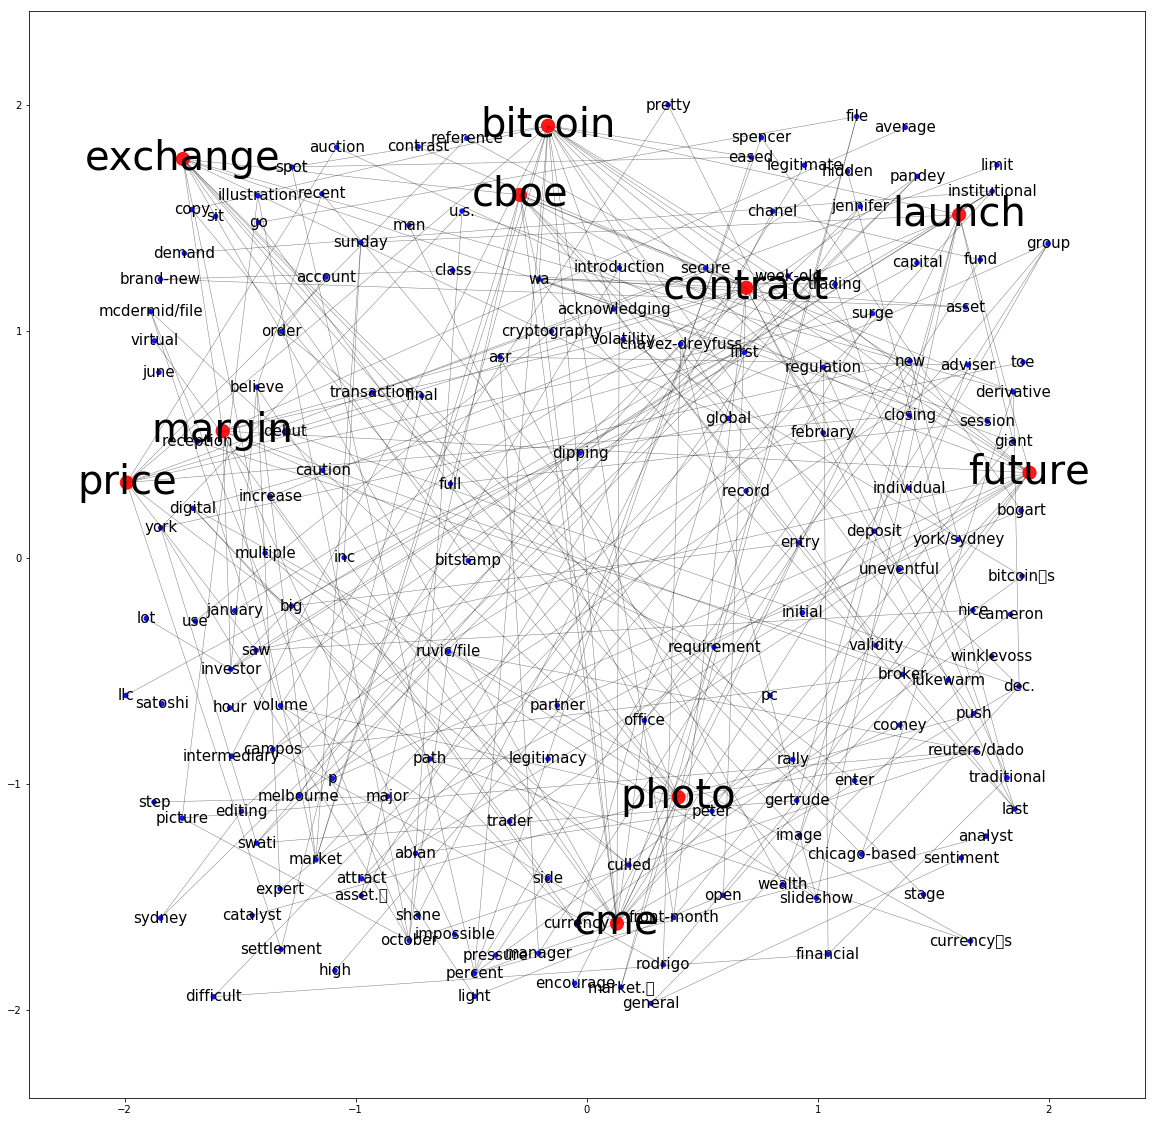

In [26]:
textrank, adj_matr, wordList_filtered = graph_info

n_top_keywords = 10
pivot = sorted(textrank)[-n_top_keywords]
textrank = np.array(textrank)
textrank[textrank < pivot] = -1
textrank += 1
textrank *= 150
textrank += 20

color_map = np.empty(textrank.shape[0], dtype='<U15')
color_map[textrank > 20] = 'red'
color_map[textrank <= 20] = 'blue'

sizes_map = np.empty(textrank.shape[0])
sizes_map[textrank > 20] = 20
sizes_map[textrank <= 20] = 7

N=adj_matr.shape[0] # number of nodes
gow = nx.Graph(adj_matr)

f, ax = plt.subplots(figsize=(20,20))

#pos=nx.spring_layout(gow, k= 1/np.sqrt(N)*35,iterations=5,weight=0.2) # positions for all nodes
pos = nx.spring_layout(gow,scale=2, iterations=2, k = 2)#nx.spectral_layout(gow, scale = 20)
nx.draw_networkx_nodes(gow,pos,
                       node_list=np.arange(len(wordList_filtered)),
                       node_color=color_map,
                       node_size=list(textrank),
                   alpha=0.9)


# edges
nx.draw_networkx_edges(gow,pos,width=0.5,arrows=True,alpha=0.5)



# some math labels
other_nodes_inds = np.where(textrank <= 20)[0]
key_nodes_inds = np.where(textrank > 20)[0]
nx.draw_networkx_labels(gow,pos,dict(zip(other_nodes_inds, wordList_filtered[other_nodes_inds])),font_size=15)
nx.draw_networkx_labels(gow,pos,dict(zip(key_nodes_inds, wordList_filtered[key_nodes_inds])),font_size=40)
print()